In [3]:
import json
import pprint
from pathlib import Path
import sys
sys.path.insert(1, '../src')
sys.path.insert(1, '../src/utils')
import ipdb
import itertools
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gensim.utils import simple_preprocess
from gensim import corpora, models
from gensim.models import Word2Vec
from gensim.models import CoherenceModel
from sklearn.manifold import TSNE, SpectralEmbedding
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.neighbors import kneighbors_graph
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
from scipy.spatial.distance import cdist

from preprocessing import Preprocessing
from config import Config 

import pickle

In [4]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Variables

In [6]:
num_topics = 15
use_title = True
# don't use stemming
stemming = False
lemmatization = True
# use nltk since it is a lot faster than spacy and the results are better with nltk
lib = "nltk"

input_path = Path("../src/data/data_jmlr_vol13-21.json")

# Data loading and preparation

## Load data

In [7]:
def load_data():
    with open(input_path, encoding="utf-8") as f:
        data = json.load(f)
    data_df = pd.json_normalize(data['papers'])
    corpus = data_df["abstract"]
    if use_title:
        corpus = data_df["title"] + " " + corpus 
    return corpus

loaded_corpus = load_data()

## Preprocessing

In [8]:
config = Config.from_file("config_notebook.yaml")
preprocessed_corpus = Preprocessing(
        loaded_corpus,
        config=config.preprocessing,
    ).apply_preprocessing()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
1261it [00:11, 114.49it/s]


### TD-IDF

In [9]:
vectorizer = TfidfVectorizer(tokenizer=lambda text: text, lowercase=False)  
tfidf_corpus = vectorizer.fit_transform(preprocessed_corpus["token"])

# Clustering

In [10]:
tdidf_agg_clustering = AgglomerativeClustering(n_clusters=num_topics, linkage='ward')
tdidf_agg_clustering.fit(tfidf_corpus.toarray())

AgglomerativeClustering(n_clusters=15)

In [ ]:
pickle.dump(tdidf_agg_clustering, open('aggclust_data/tdidf_agg_clustering', 'wb'))

In [11]:
def get_top_words(vectorizer, corpus):
    scores = zip(vectorizer.get_feature_names(),
                 np.asarray(corpus.sum(axis=0)).ravel())
    sorted_scores = list(zip(*sorted(scores, key=lambda x: x[1], reverse=True)))
    top_words = sorted_scores[0][:10]
    return top_words
    

def print_and_get_clusters(model, corpus):  
    n_clusters_ = len(np.unique(model.labels_))
    
    clusters = []
    print("Top terms per cluster:")
    for i in range(n_clusters_):
        print("Cluster %d:" % i)
        vectorizer_terms = TfidfVectorizer(tokenizer=lambda text: text, lowercase=False)  
        tfidf_corpus_terms = vectorizer_terms.fit_transform(corpus.iloc[np.where(model.labels_ == i)]["token"])
        top_words = get_top_words(vectorizer_terms, tfidf_corpus_terms)
        print(top_words)
        clusters.append(top_words)
        print("\n")
    return clusters

In [12]:
clusters = print_and_get_clusters(tdidf_agg_clustering, preprocessed_corpus)

Top terms per cluster:
Cluster 0:
('model', 'learning', 'algorithm', 'data', 'method', 'problem', 'function', 'feature', 'set', 'approach')


Cluster 1:
('model', 'graphical', 'lasso', 'covariance', 'data', 'matrix', 'method', 'estimator', 'gaussian', 'graph')


Cluster 2:
('learning', 'label', 'data', 'algorithm', 'class', 'classification', 'classifier', 'machine', 'svm', 'method')


Cluster 3:
('gaussian', 'process', 'model', 'inference', 'variational', 'algorithm', 'approximation', 'bayesian', 'method', 'prior')


Cluster 4:
('network', 'model', 'community', 'neural', 'node', 'layer', 'data', 'algorithm', 'method', 'learning')


Cluster 5:
('kernel', 'distributed', 'algorithm', 'regression', 'rate', 'method', 'learning', 'data', 'function', 'bound')


Cluster 6:
('clustering', 'cluster', 'algorithm', 'graph', 'data', 'based', 'spectral', 'matrix', 'model', 'number')


Cluster 7:
('causal', 'data', 'effect', 'variable', 'method', 'discovery', 'approach', 'model', 'set', 'algorithm')


# Visualization

In [13]:
def visualize_clustering_result_arr(model, X):
    labels = model.labels_
    print("Number of points: %i" % labels.size)

    for l in np.unique(labels):
        plt.scatter(X[labels == l, 0], X[labels == l, 1],
                   color=plt.cm.jet(float(l) / np.max(labels + 1)),
                   s=20, edgecolor='k')
    plt.show()

def visualize_clustering_result(model, corpus):
    X = corpus.toarray()
    visualize_clustering_result_arr(model, X)

Number of points: 1261


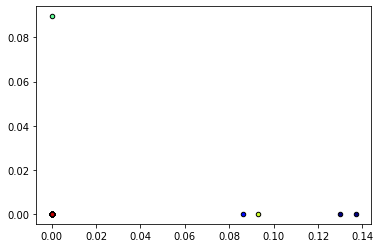

In [14]:
visualize_clustering_result(tdidf_agg_clustering, tfidf_corpus)

# Try different arguments for `AgglomerativeClustering`

In [15]:
connectivity = kneighbors_graph(tfidf_corpus.toarray(), n_neighbors=10, include_self=False)

In [18]:
tdidf_agg_clustering_conn = AgglomerativeClustering(connectivity=connectivity, n_clusters=num_topics, linkage='ward')
tdidf_agg_clustering_conn.fit(tfidf_corpus.toarray())
pickle.dump(tdidf_agg_clustering, open('aggclust_data/tdidf_agg_clustering_conn', 'wb'))

AgglomerativeClustering(connectivity=<1261x1261 sparse matrix of type '<class 'numpy.float64'>'
	with 12610 stored elements in Compressed Sparse Row format>,
                        n_clusters=15)

In [19]:
clusters = print_and_get_clusters(tdidf_agg_clustering_conn, preprocessed_corpus)

Top terms per cluster:
Cluster 0:
('kernel', 'density', 'estimation', 'estimator', 'mean', 'learning', 'algorithm', 'data', 'cluster', 'function')


Cluster 1:
('model', 'learning', 'data', 'algorithm', 'method', 'problem', 'feature', 'function', 'set', 'based')


Cluster 2:
('model', 'graphical', 'algorithm', 'network', 'graph', 'lasso', 'data', 'method', 'covariance', 'matrix')


Cluster 3:
('model', 'process', 'variational', 'gaussian', 'inference', 'method', 'approximation', 'prior', 'approach', 'bayesian')


Cluster 4:
('regression', 'rate', 'learning', 'kernel', 'algorithm', 'distributed', 'method', 'convergence', 'error', 'bound')


Cluster 5:
('learning', 'manifold', 'machine', 'package', 'ensemble', 'python', 'library', 'data', 'algorithm', 'toolbox')


Cluster 6:
('algorithm', 'method', 'stochastic', 'convex', 'gradient', 'optimization', 'problem', 'function', 'convergence', 'distributed')


Cluster 7:
('causal', 'effect', 'data', 'variable', 'model', 'method', 'discovery', '

Number of points: 1261


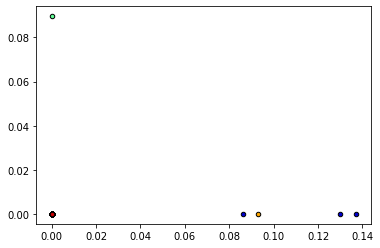

In [20]:
visualize_clustering_result(tdidf_agg_clustering_conn, tfidf_corpus)

# Spectral embedding

In [21]:
vectorizer_spec_embedding = TfidfVectorizer(tokenizer=lambda text: text, lowercase=False)  
tfidf_corpus_spec_embedding = vectorizer_spec_embedding.fit_transform(preprocessed_corpus["token"])
tfidf_corpus_spec_embedding_array = SpectralEmbedding(n_components=2).fit_transform(tfidf_corpus_spec_embedding.toarray())

In [22]:
tdidf_agg_clustering_spectral = AgglomerativeClustering(n_clusters=num_topics, linkage='ward')
tdidf_agg_clustering_spectral.fit(tfidf_corpus_spec_embedding_array)
pickle.dump(tdidf_agg_clustering_spectral, open('aggclust_data/tdidf_agg_clustering_spectral', 'wb'))

AgglomerativeClustering(n_clusters=15)

In [23]:
clusters = print_and_get_clusters(tdidf_agg_clustering_spectral, preprocessed_corpus)

Top terms per cluster:
Cluster 0:
('learning', 'python', 'library', 'data', 'model', 'source', 'machine', 'time', 'toolbox', 'open')


Cluster 1:
('learning', 'algorithm', 'policy', 'problem', 'method', 'bound', 'function', 'kernel', 'optimization', 'sample')


Cluster 2:
('learning', 'machine', 'algorithm', 'multi', 'library', 'framework', 'label', 'classification', 'package', 'data')


Cluster 3:
('model', 'graph', 'graphical', 'algorithm', 'causal', 'data', 'variable', 'latent', 'method', 'inference')


Cluster 4:
('model', 'data', 'method', 'algorithm', 'variable', 'gaussian', 'approach', 'clustering', 'inference', 'bayesian')


Cluster 5:
('algorithm', 'kernel', 'method', 'regression', 'data', 'model', 'problem', 'learning', 'bound', 'approximation')


Cluster 6:
('algorithm', 'method', 'stochastic', 'function', 'convex', 'optimization', 'loss', 'problem', 'gradient', 'convergence')


Cluster 7:
('regression', 'matrix', 'rank', 'bound', 'algorithm', 'norm', 'method', 'problem', 'r

Number of points: 1261


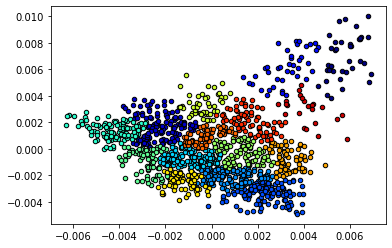

In [24]:
visualize_clustering_result_arr(tdidf_agg_clustering_spectral, tfidf_corpus_spec_embedding_array)

#  Remove words which appear often in all clusters

In [25]:
terms = list(itertools.chain.from_iterable(clusters))
Counter(terms).most_common

<bound method Counter.most_common of Counter({'algorithm': 13, 'data': 11, 'learning': 10, 'method': 10, 'model': 9, 'problem': 6, 'kernel': 4, 'time': 3, 'bound': 3, 'function': 3, 'optimization': 3, 'inference': 3, 'regression': 3, 'python': 2, 'library': 2, 'machine': 2, 'policy': 2, 'multi': 2, 'package': 2, 'graph': 2, 'causal': 2, 'variable': 2, 'approach': 2, 'matrix': 2, 'rank': 2, 'feature': 2, 'set': 2, 'network': 2, 'task': 2, 'neural': 2, 'source': 1, 'toolbox': 1, 'open': 1, 'sample': 1, 'framework': 1, 'label': 1, 'classification': 1, 'graphical': 1, 'latent': 1, 'gaussian': 1, 'clustering': 1, 'bayesian': 1, 'approximation': 1, 'stochastic': 1, 'convex': 1, 'loss': 1, 'gradient': 1, 'convergence': 1, 'norm': 1, 'rate': 1, 'prediction': 1, 'active': 1, 'reinforcement': 1, 'estimator': 1, 'sparse': 1, 'lasso': 1, 'estimation': 1, 'deep': 1, 'class': 1, 'classifier': 1, 'training': 1, 'gesture': 1, 'system': 1, 'image': 1, 'recognition': 1})>

In [26]:
custom_stopwords = ["algorithm", "data", "learning"]

In [27]:
corpus_new = load_data()

config = Config.from_file("config_notebook_stopwords.yaml")
corpus_stopwords = Preprocessing(
        corpus_new,
        config=config.preprocessing,
    ).apply_preprocessing()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
1261it [00:05, 218.34it/s]


In [28]:
vectorizer_stopwords = TfidfVectorizer(tokenizer=lambda text: text, lowercase=False)  
tfidf_corpus_stopwords = vectorizer_stopwords.fit_transform(corpus_stopwords["token"])

In [29]:
tdidf_agg_clustering_stopwords = AgglomerativeClustering(n_clusters=num_topics, linkage='ward')
tdidf_agg_clustering_stopwords.fit(tfidf_corpus_stopwords.toarray())
pickle.dump(tdidf_agg_clustering, open('aggclust_data/tdidf_agg_clustering_stopwords', 'wb'))

AgglomerativeClustering(n_clusters=15)

Number of points: 1261


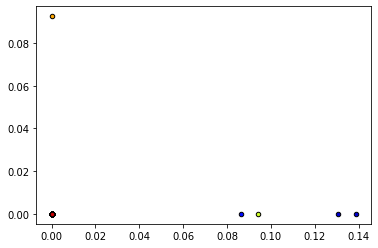

In [30]:
visualize_clustering_result(tdidf_agg_clustering_stopwords, tfidf_corpus_stopwords)

In [31]:
clusters = print_and_get_clusters(tdidf_agg_clustering_stopwords, corpus_stopwords)

Top terms per cluster:
Cluster 0:
('problem', 'function', 'set', 'approach', 'based', 'time', 'distribution', 'matrix', 'class', 'show')


Cluster 1:
('regression', 'loss', 'rate', 'bound', 'kernel', 'problem', 'norm', 'risk', 'function', 'linear')


Cluster 2:
('manifold', 'machine', 'library', 'package', 'python', 'ensemble', 'gesture', 'source', 'optimization', 'toolbox')


Cluster 3:
('stochastic', 'convex', 'gradient', 'problem', 'distributed', 'optimization', 'function', 'convergence', 'non', 'rate')


Cluster 4:
('network', 'community', 'neural', 'layer', 'node', 'structure', 'cascade', 'detection', 'distribution', 'estimation')


Cluster 5:
('graph', 'dag', 'random', 'markov', 'problem', 'distribution', 'class', 'node', 'time', 'equivalence')


Cluster 6:
('graphical', 'lasso', 'selection', 'feature', 'change', 'variable', 'high', 'gaussian', 'dimensional', 'network')


Cluster 7:
('clustering', 'cluster', 'graph', 'based', 'spectral', 'matrix', 'number', 'set', 'result', 'anal

# Metrics

In [32]:
def calc_scores_arr(corpus, model):
    return metrics.silhouette_score(corpus, model.labels_, metric='euclidean'), metrics.calinski_harabasz_score(corpus, model.labels_), metrics.davies_bouldin_score(corpus, model.labels_)

def calc_scores(corpus, model):
    return calc_scores_arr(corpus.toarray(), model)
    

In [33]:
scores = []

score = list(calc_scores(tfidf_corpus, tdidf_agg_clustering))
score.insert(0, 'normal model')
scores.append(score)

score = list(calc_scores(tfidf_corpus_stopwords, tdidf_agg_clustering_stopwords))
score.insert(0, 'model with custom stopwords')
scores.append(score)

score = list(calc_scores(tfidf_corpus, tdidf_agg_clustering_conn))
score.insert(0, 'model with connectivity')
scores.append(score)

score = list(calc_scores_arr(tfidf_corpus_spec_embedding_array, tdidf_agg_clustering_spectral))
score.insert(0, 'model with spectral embedding')
scores.append(score)


scores = pd.DataFrame(scores, columns=["model type","silhouette_score", "calinski_harabasz_score", "davies_bouldin_score"])
print(scores)

                      model type  silhouette_score  calinski_harabasz_score  \
0                   normal model          0.000467                 4.084053   
1    model with custom stopwords          0.001866                 4.153627   
2        model with connectivity          0.001950                 4.072045   
3  model with spectral embedding          0.300136              1029.213757   

   davies_bouldin_score  
0              6.231226  
1              6.278349  
2              6.388895  
3              0.904163  


# Test with LSA

In [34]:
def get_lsa_transformation(n_components, corpus):
    svd = TruncatedSVD(n_components)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)
    return lsa.fit_transform(corpus),svd

In [35]:
n_components = 2
X, svd = get_lsa_transformation(n_components, tfidf_corpus)

tdidf_agg_clustering_lsa = AgglomerativeClustering(n_clusters=num_topics, linkage='ward')
tdidf_agg_clustering_lsa.fit(X)
pickle.dump(tdidf_agg_clustering_lsa, open('aggclust_data/tdidf_agg_clustering_lsa', 'wb'))

AgglomerativeClustering(n_clusters=15)

In [36]:
clusters = print_and_get_clusters(tdidf_agg_clustering_lsa, preprocessed_corpus)

Top terms per cluster:
Cluster 0:
('stochastic', 'convex', 'algorithm', 'optimization', 'gradient', 'loss', 'convergence', 'problem', 'function', 'rate')


Cluster 1:
('model', 'data', 'learning', 'network', 'graph', 'algorithm', 'method', 'gaussian', 'time', 'process')


Cluster 2:
('learning', 'algorithm', 'method', 'data', 'model', 'matrix', 'problem', 'set', 'based', 'estimator')


Cluster 3:
('learning', 'algorithm', 'matrix', 'problem', 'bound', 'kernel', 'method', 'optimization', 'data', 'rank')


Cluster 4:
('model', 'graph', 'network', 'causal', 'inference', 'graphical', 'latent', 'data', 'variable', 'learning')


Cluster 5:
('data', 'learning', 'model', 'algorithm', 'method', 'problem', 'random', 'feature', 'information', 'set')


Cluster 6:
('kernel', 'learning', 'algorithm', 'function', 'method', 'problem', 'regression', 'optimization', 'matrix', 'online')


Cluster 7:
('learning', 'algorithm', 'data', 'method', 'model', 'matrix', 'problem', 'sparse', 'feature', 'cluster')


Number of points: 1261


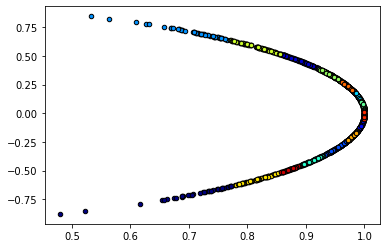

In [37]:
visualize_clustering_result_arr(tdidf_agg_clustering_lsa, X)

In [38]:
scores = []

score = list(calc_scores_arr(X, tdidf_agg_clustering_lsa))
score.insert(0, 'model with lsa embedding')
scores.append(score)


scores = pd.DataFrame(scores, columns=["model type","silhouette_score", "calinski_harabasz_score", "davies_bouldin_score"])
print(scores)

                 model type  silhouette_score  calinski_harabasz_score  \
0  model with lsa embedding          0.512373             10238.480445   

   davies_bouldin_score  
0              0.509119  


# Jessis plotting method

In [39]:
def plot(model, corpus, input_dense=False):
    random_state = 1
    #centroids = model.cluster_centers_

    tsne_init = 'pca'  # could also be 'random'
    tsne_perplexity = 20.0
    tsne_early_exaggeration = 4.0
    tsne_learning_rate = 10
    tsne = TSNE(n_components=2, random_state=random_state, init=tsne_init,
        perplexity=tsne_perplexity,
        early_exaggeration=tsne_early_exaggeration, learning_rate=tsne_learning_rate)
    
    if input_dense:
        transformed = tsne.fit_transform(corpus)
    else:
        transformed = tsne.fit_transform(corpus.todense())
    plt.scatter(transformed[:, 0], transformed[:, 1], c=model.labels_, marker='x')
    plt.show()

## Normal

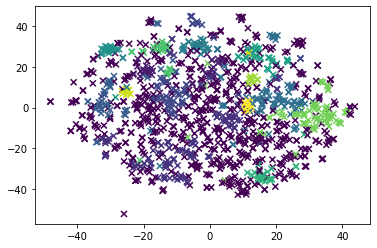

In [40]:
plot(tdidf_agg_clustering, tfidf_corpus)

## Spectral

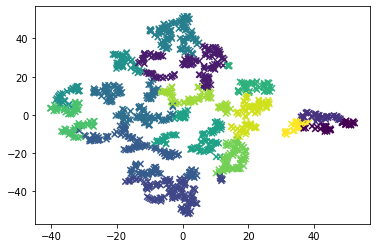

In [41]:
plot(tdidf_agg_clustering_spectral, tfidf_corpus_spec_embedding_array, True)

## LSA

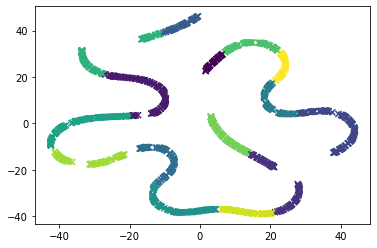

In [42]:
plot(tdidf_agg_clustering_lsa, X, True)